In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import graphviz 
from sklearn import tree
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data.head(5)

,weight,height,closing,open_00_02,open_02_04,open_04_06,open_06_08,open_08_10,open_10_12,open_12_14,...,cuisine_y_Regional,cuisine_y_Seafood,cuisine_y_Vietnamese,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,smoking,age,target
0,69,1.77,12,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,32,2
1,69,1.77,24,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,32,0
2,69,1.77,20,0,0,0,0,0,1,1,...,0,1,0,0,0,0,1,0,32,1
3,69,1.77,23,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,32,2
4,69,1.77,23,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,32,2


In [3]:
def split_data(data_x: np.ndarray, data_y: np.ndarray):
    
    ordering = np.arange(data_x.shape[0])
    np.random.shuffle(ordering)
    data_x = data_x[ordering]
    data_y = data_y[ordering]
    
    valid_start = int(len(data_x) * 0.7)
    test_start = int(len(data_x) * 0.9)
    
    train_set = (data_x[:valid_start], data_y[:valid_start])
    valid_set = (data_x[valid_start:test_start], data_y[valid_start:test_start])
    test_set = (data_x[test_start:], data_y[test_start:])
    
    return train_set, valid_set, test_set

In [4]:
y = np.array(data['target'])
x = np.array(data.drop(['target'], axis=1))

train_set, valid_set, test_set = split_data(x,y)

x_train = train_set[0]
y_train = train_set[1]

x_val = valid_set[0]
y_val = valid_set[1]

x_test = test_set[0]
y_test = test_set[1]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2055, 134)
(587, 134)
(294, 134)


## One tree to go 

In [5]:
n=24
depth_arr = np.linspace(2, 25, 24)
train_accuracy = np.zeros(n)
val_accuracy = np.zeros(n)

for ind, depth in enumerate(depth_arr):    
    
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy', splitter='best')
    clf = clf.fit(x_train, y_train)

    
    output = clf.predict(x_train)
    target = y_train
    train_accuracy[ind] =sum(output == target)/ len(target)
    
    output = clf.predict(x_val)
    target = y_val
    val_accuracy[ind] =sum(output == target)/ len(target)

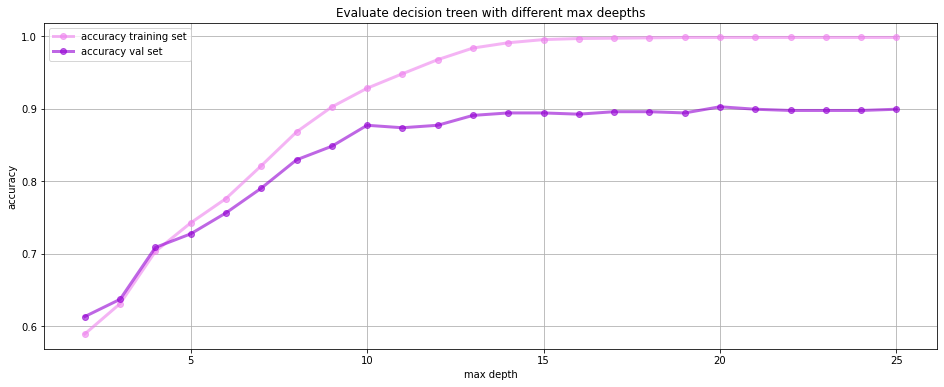

In [6]:
# Plotting
plt.figure(figsize=(16, 6))

plt.plot(depth_arr, train_accuracy, 'bo-', label=r'accuracy training set', color="violet", alpha=0.6, linewidth=3)
plt.plot(depth_arr, val_accuracy, 'bo-', label=r'accuracy val set', color="darkviolet", alpha=0.6, linewidth=3)

plt.xlabel('max depth'); plt.ylabel(r'accuracy')
plt.title(r'Evaluate decision treen with different max deepths')
plt.legend(loc='best')
plt.grid()

In [7]:
## Basically, after max_depth = 13 nothing better happens

random_state= np.random.randint(low=0, high=1e5)

clf = tree.DecisionTreeClassifier(max_depth=13, criterion='entropy', splitter='best', random_state=random_state)
clf = clf.fit(x_train, y_train)

output = clf.predict(x_val)
target = y_val
accuracy =sum(output == target)/ len(target)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

#feature_names = list(data.columns)[:-1]
#dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,filled=True, rounded=True)
#graph = graphviz.Source(dot_data)  
#png_bytes = graph.pipe(format='png')
#with open('dtree_pipe1.png','wb') as f:
#    f.write(png_bytes)

#from IPython.display import Image
#Image(png_bytes)

Accuracy on validation set: 89.61 %


## START WITH ENSEMBLING METHODS

In [8]:
def create_bootstrap_data():
    bootstrap_ids = np.random.randint(0, len(x_train), size=len(x_train))
    return x_train[bootstrap_ids,:], y_train[bootstrap_ids]

In [9]:
def build_classifier(data_set, labels, max_depth):
    random_state= np.random.randint(low=0, high=1e5)
    decision_tree = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split=3, min_samples_leaf=2, random_state=random_state)
    decision_tree.fit(data_set, labels)
    return decision_tree

In [10]:
def build_classifiers(cases, max_depth):
    classifiers = []
    for case in range(cases):
        bootstrap_set, bootstrap_labels = create_bootstrap_data()
        classifier = build_classifier(bootstrap_set, bootstrap_labels, max_depth)
        classifiers.append(classifier)
    return classifiers

In [11]:
def vote(classifiers, test_data):
    output = []
    for classifier in classifiers:
        output.append(classifier.predict(test_data))
    output = np.array(output)
    predicted = []
    for i in range(len(test_data)):
        classified = output[:, i]
        counts = np.bincount(classified)
        predicted.append(np.argmax(counts))
    return predicted

## Grid search:

In [12]:
m_arr = np.arange(50, 150, 10)
depth_arr = np.linspace(6, 20, 15)

for m in m_arr:
    for max_depth in depth_arr:
        classifiers = build_classifiers(m, max_depth)
        predicted = vote(classifiers, x_val)
        accuracy = accuracy_score(y_val, predicted)
        print("Accuracy on validation set: {:.2f} using m={:} and depth = {:}".format(accuracy*100, m, max_depth))

Accuracy on validation set: 81.94 using m=50 and depth = 6.0
Accuracy on validation set: 83.30 using m=50 and depth = 7.0
Accuracy on validation set: 84.50 using m=50 and depth = 8.0
Accuracy on validation set: 86.37 using m=50 and depth = 9.0
Accuracy on validation set: 87.73 using m=50 and depth = 10.0
Accuracy on validation set: 88.25 using m=50 and depth = 11.0
Accuracy on validation set: 89.27 using m=50 and depth = 12.0
Accuracy on validation set: 89.44 using m=50 and depth = 13.0
Accuracy on validation set: 88.93 using m=50 and depth = 14.0
Accuracy on validation set: 89.78 using m=50 and depth = 15.0
Accuracy on validation set: 89.61 using m=50 and depth = 16.0
Accuracy on validation set: 89.95 using m=50 and depth = 17.0
Accuracy on validation set: 89.61 using m=50 and depth = 18.0
Accuracy on validation set: 88.93 using m=50 and depth = 19.0
Accuracy on validation set: 90.12 using m=50 and depth = 20.0
Accuracy on validation set: 81.26 using m=60 and depth = 6.0
Accuracy on v

Accuracy on validation set: 90.29 using m=130 and depth = 18.0
Accuracy on validation set: 90.29 using m=130 and depth = 19.0
Accuracy on validation set: 90.12 using m=130 and depth = 20.0
Accuracy on validation set: 81.77 using m=140 and depth = 6.0
Accuracy on validation set: 83.65 using m=140 and depth = 7.0
Accuracy on validation set: 85.01 using m=140 and depth = 8.0
Accuracy on validation set: 87.05 using m=140 and depth = 9.0
Accuracy on validation set: 87.90 using m=140 and depth = 10.0
Accuracy on validation set: 88.25 using m=140 and depth = 11.0
Accuracy on validation set: 89.61 using m=140 and depth = 12.0
Accuracy on validation set: 89.61 using m=140 and depth = 13.0
Accuracy on validation set: 89.78 using m=140 and depth = 14.0
Accuracy on validation set: 89.95 using m=140 and depth = 15.0
Accuracy on validation set: 90.46 using m=140 and depth = 16.0
Accuracy on validation set: 90.12 using m=140 and depth = 17.0
Accuracy on validation set: 89.78 using m=140 and depth = 1

In [13]:
m = 100
max_depth = 12
classifiers = build_classifiers(m, max_depth)
predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on validation set: 88.93 %


In [14]:
m = 25
max_depth = 13
classifiers = build_classifiers(m, max_depth)
predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on validation set: 89.44 %


# FINAL EVALUATION OF THE MODEL

In [15]:
m = 25
max_depth = 13
classifiers = build_classifiers(m, max_depth)

predicted = vote(classifiers, x_train)
accuracy = accuracy_score(y_train, predicted)
print("Accuracy on trainig set: {:.2f} %".format(accuracy*100))

predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))


predicted = vote(classifiers, x_test)
accuracy = accuracy_score(y_test, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on trainig set: 98.44 %
Accuracy on validation set: 88.59 %
Accuracy on validation set: 90.48 %
